In [1]:
import pandas as pd

# Load the uploaded CSV files
file_path_train = 'electric_consumption_till_24june.csv'
file_path_test = 'electric_consumption_till_25jun (1).csv'

# Read the datasets
train_data = pd.read_csv(file_path_train)
test_data = pd.read_csv(file_path_test)

# Display the first few rows of each dataset
train_data_head = train_data.head()
test_data_head = test_data.head()
train_data_head, test_data_head


(   Unnamed: 0                 Date  Homestead_maxtempC  Homestead_mintempC  \
 0           0  2020-06-24 23:00:00                34.0                28.0   
 1           1  2020-06-24 22:00:00                34.0                28.0   
 2           2  2020-06-24 21:00:00                34.0                28.0   
 3           3  2020-06-24 20:00:00                34.0                28.0   
 4           4  2020-06-24 19:00:00                34.0                28.0   
 
    Homestead_DewPointC  Homestead_FeelsLikeC  Homestead_HeatIndexC  \
 0                 25.0                  34.0                  34.0   
 1                 25.0                  34.0                  34.0   
 2                 25.0                  35.0                  35.0   
 3                 24.0                  35.0                  35.0   
 4                 24.0                  36.0                  36.0   
 
    Homestead_WindChillC  Homestead_WindGustKmph  Homestead_cloudcover  \
 0                  29

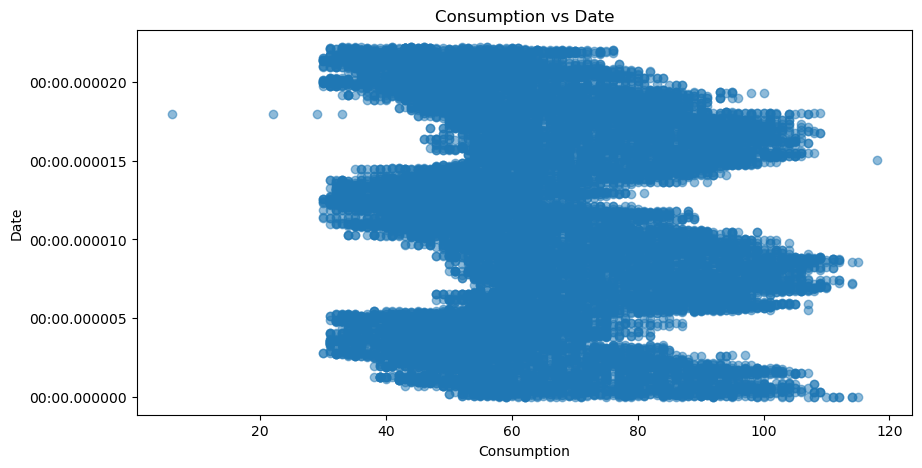

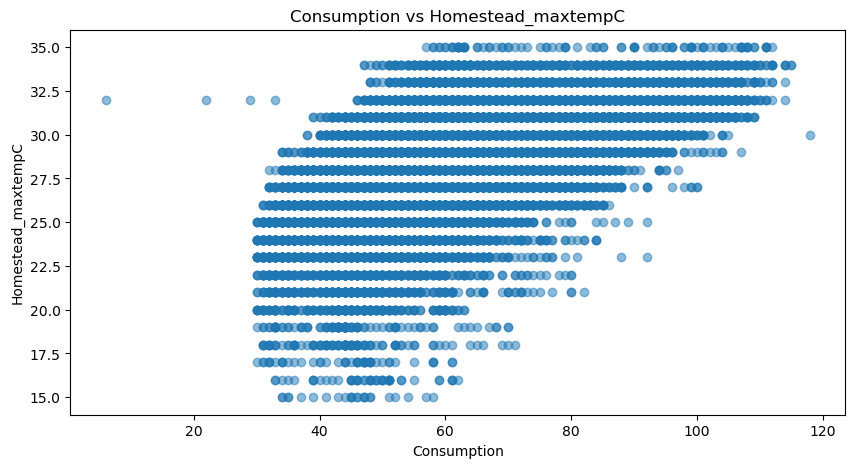

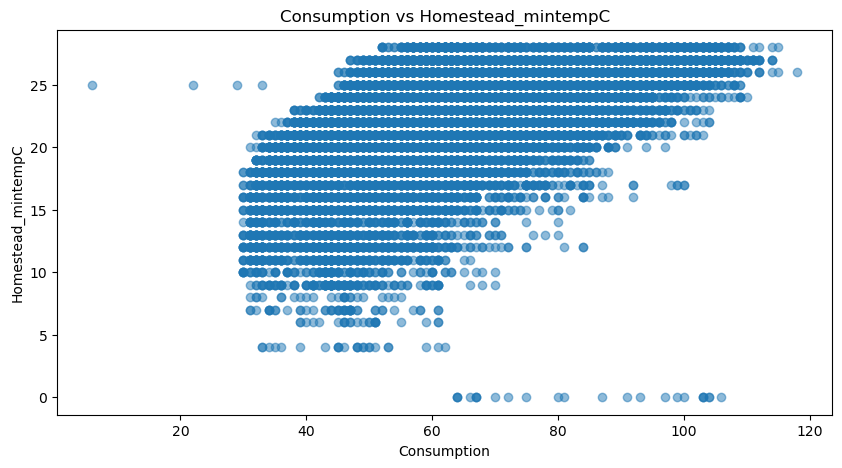

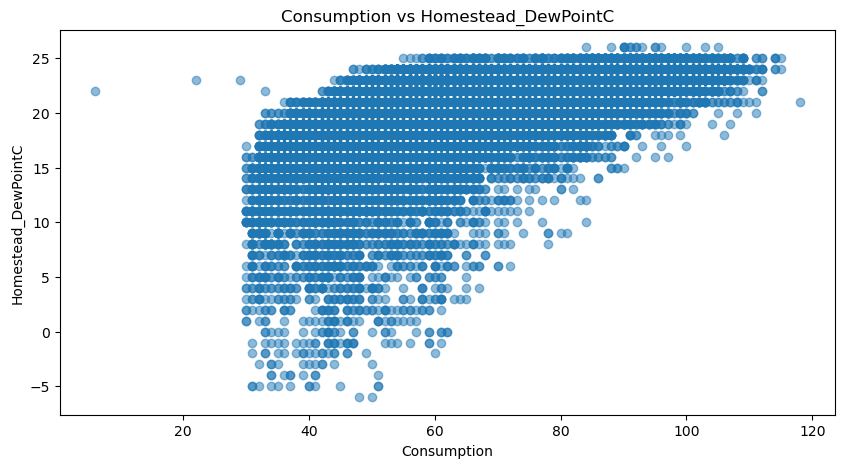

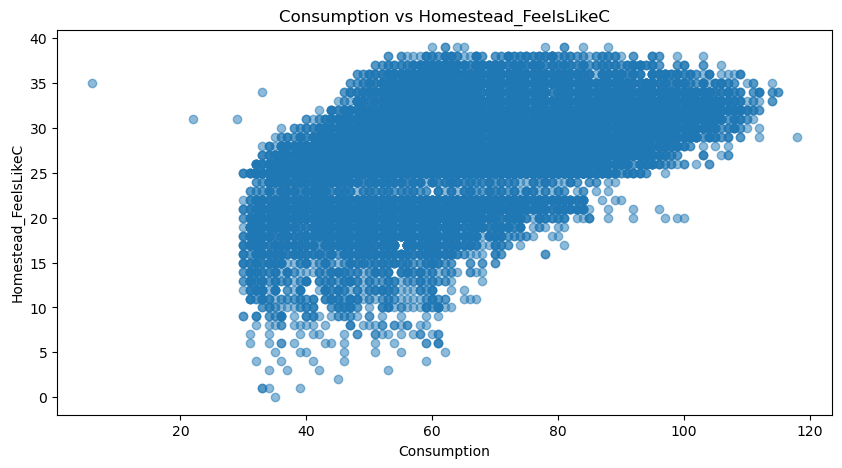

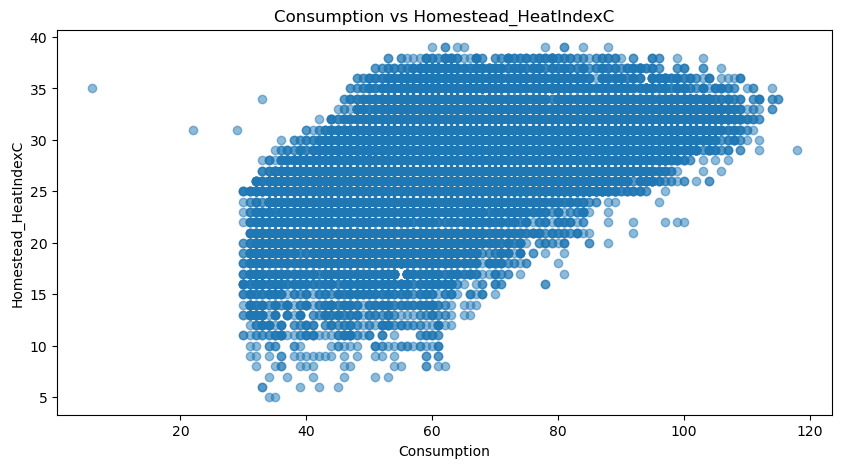

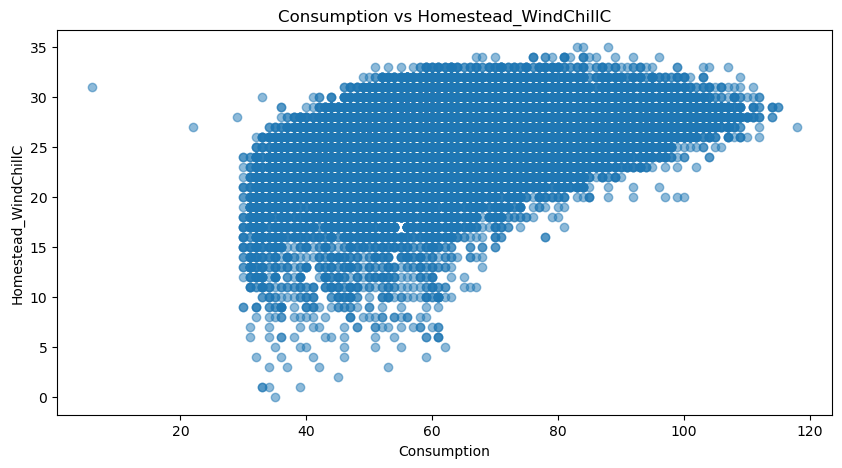

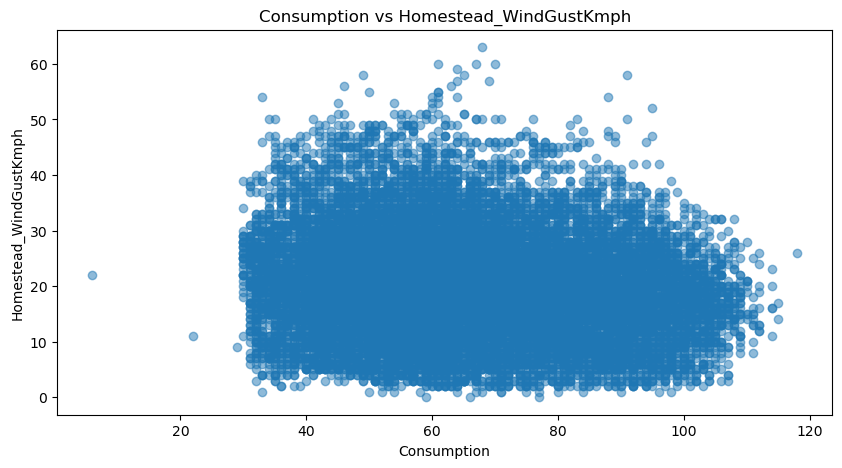

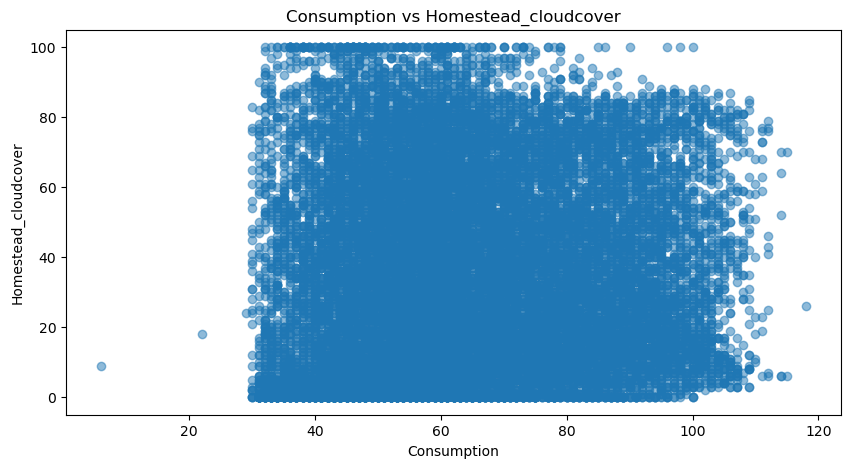

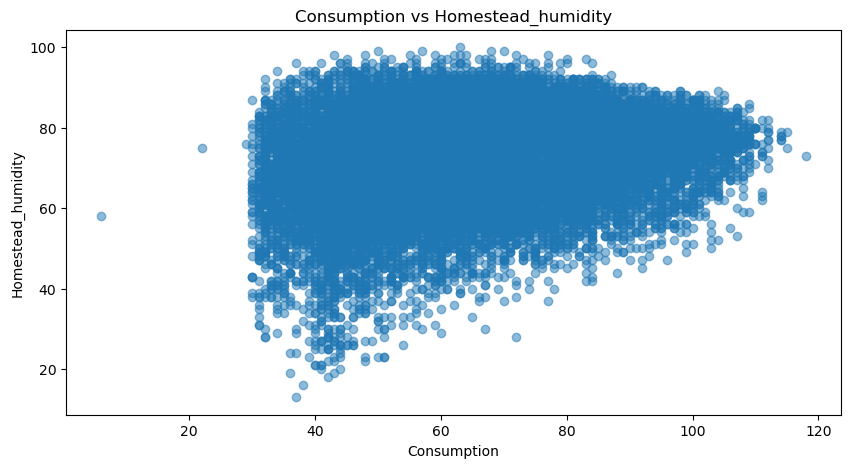

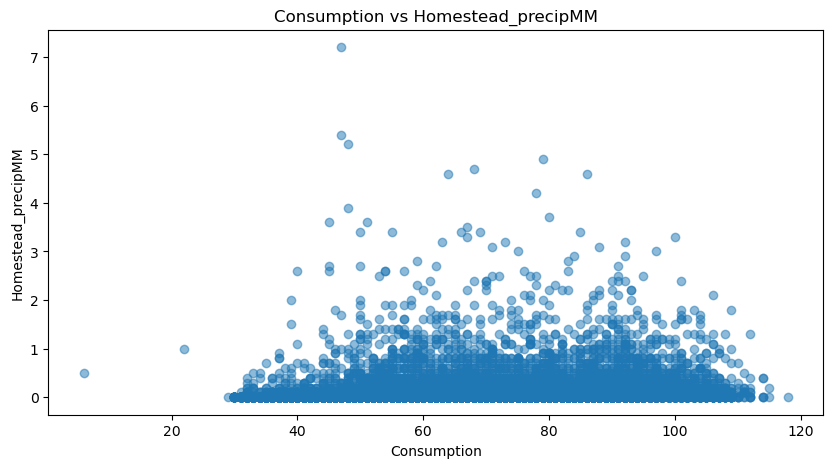

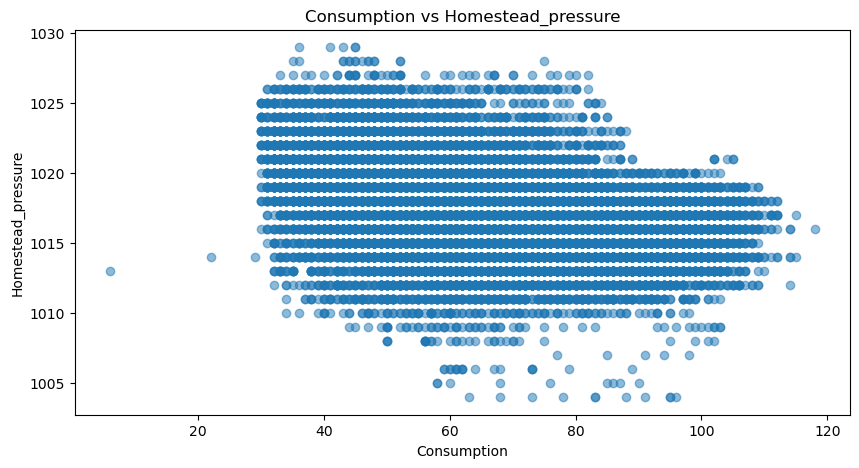

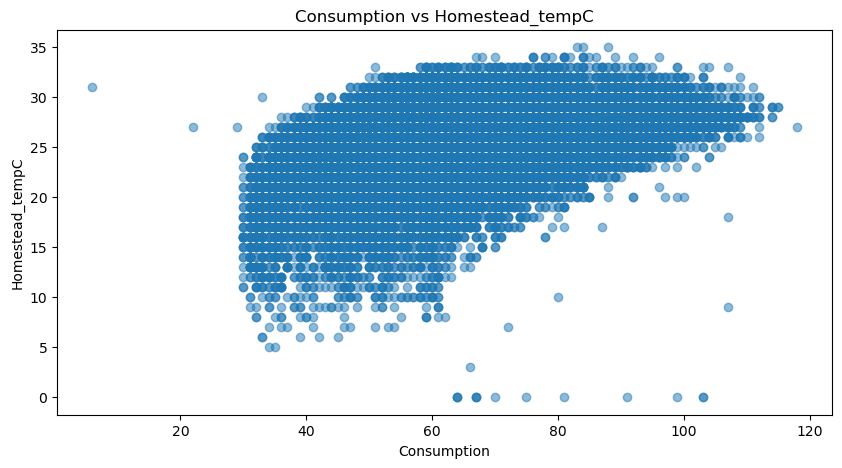

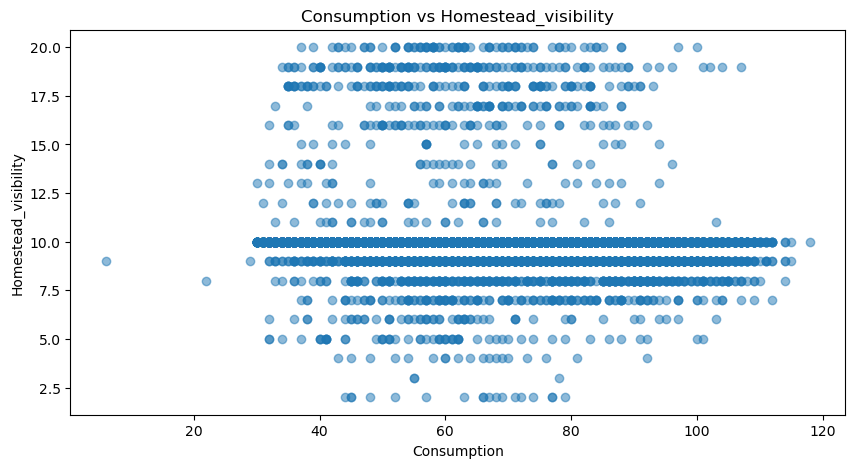

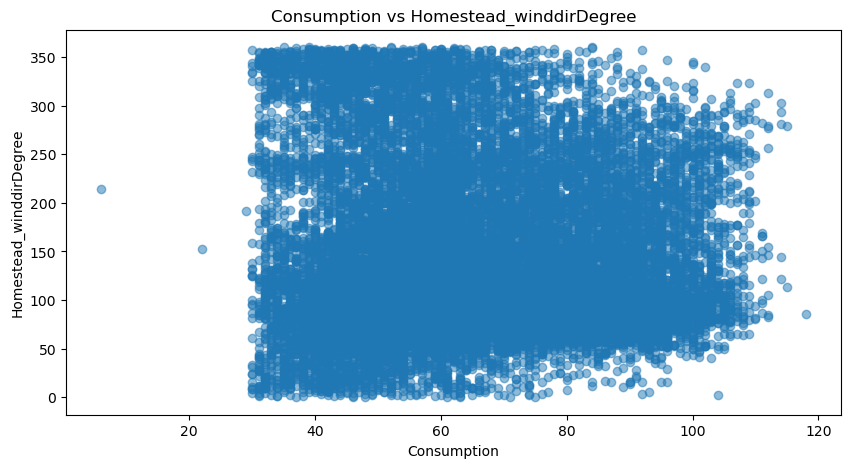

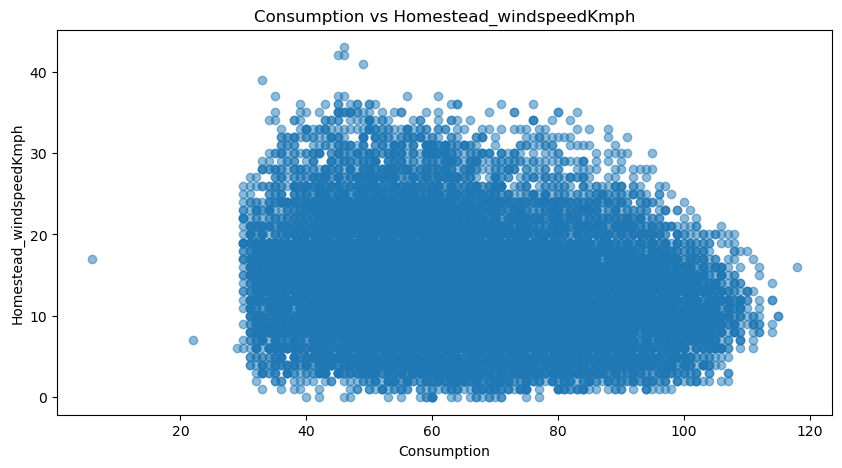

Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0147
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0015
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 7.5441e-04
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 5.1668e-04
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 4.7806e-04
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 4.9189e-04
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 4.3441e-04
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 4.5609e-04
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 4.6957e-04
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 4.3246e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Test RMSE: 15.098858766156361


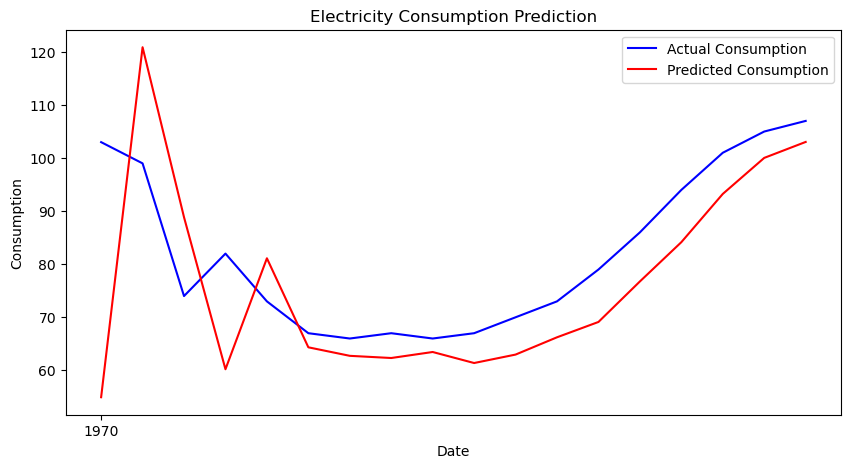

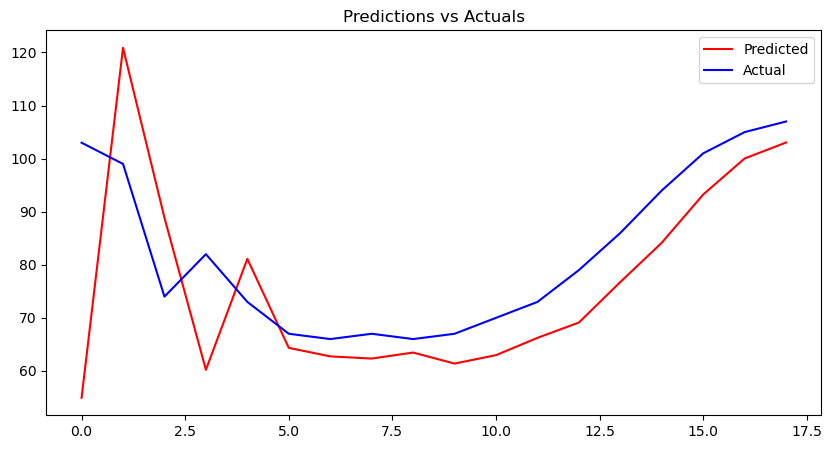

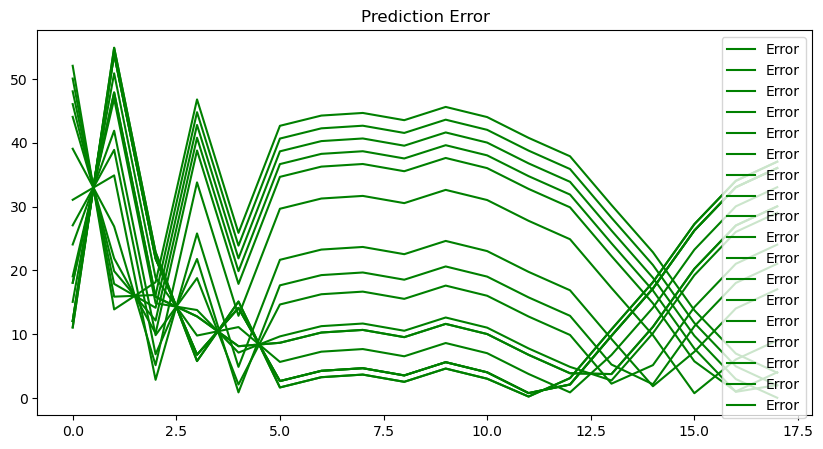

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error

# Load the datasets
data1 = pd.read_csv('electric_consumption_till_24june.csv')
data2 = pd.read_csv('electric_consumption_till_25jun (1).csv')

# Convert the date column to datetime, assuming the first column is the date
data1['Date'] = pd.to_datetime(data1.iloc[:, 0])
data2['Date'] = pd.to_datetime(data2.iloc[:, 0])

# Plot "Consumption" vs each other column in the first dataset
for column in data1.columns[1:]:  # Skip the date column
    if column != 'Consumption':  # Avoid plotting Consumption vs Consumption
        plt.figure(figsize=(10, 5))
        plt.scatter(data1['Consumption'], data1[column], alpha=0.5)
        plt.title(f"Consumption vs {column}")
        plt.xlabel("Consumption")
        plt.ylabel(column)
        plt.show()

# Preparing data for LSTM
# Extract the 'Consumption' values without column names for scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler.fit_transform(data1[['Consumption']].values)

# Define sequence length and reshape data
sequence_length = 60  # Number of time steps to look back
X_train, y_train = [], []
for i in range(sequence_length, len(data1_scaled)):
    X_train.append(data1_scaled[i-sequence_length:i, 0])
    y_train.append(data1_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test dataset
data_total = pd.concat((data1[['Consumption']], data2[['Consumption']]), axis=0)
inputs = data_total[len(data_total) - len(data2) - sequence_length:].values
inputs = scaler.transform(inputs)

X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and calculate accuracy
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

# Calculate RMSE for accuracy
test_data = data2['Consumption'].values
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse)

# Plot the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(data2['Date'], test_data, color="blue", label="Actual Consumption")
plt.plot(data2['Date'], predictions, color="red", label="Predicted Consumption")
plt.title("Electricity Consumption Prediction")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

# Plot accuracy and error
plt.figure(figsize=(10, 5))
plt.plot(predictions, color="red", label="Predicted")
plt.plot(test_data, color="blue", label="Actual")
plt.title("Predictions vs Actuals")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(abs(predictions - test_data), color="green", label="Error")
plt.title("Prediction Error")
plt.legend()
plt.show()


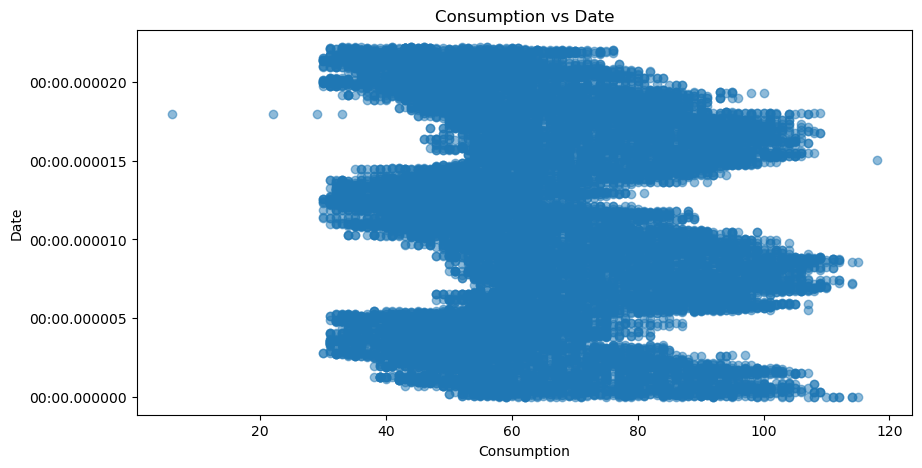

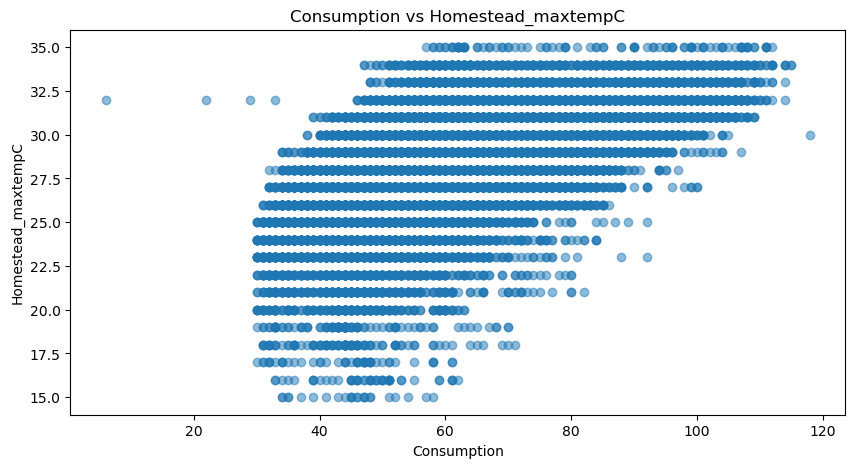

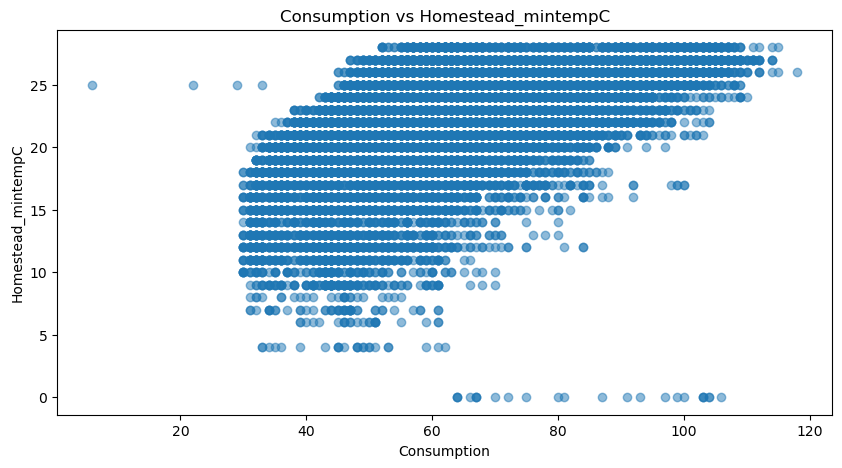

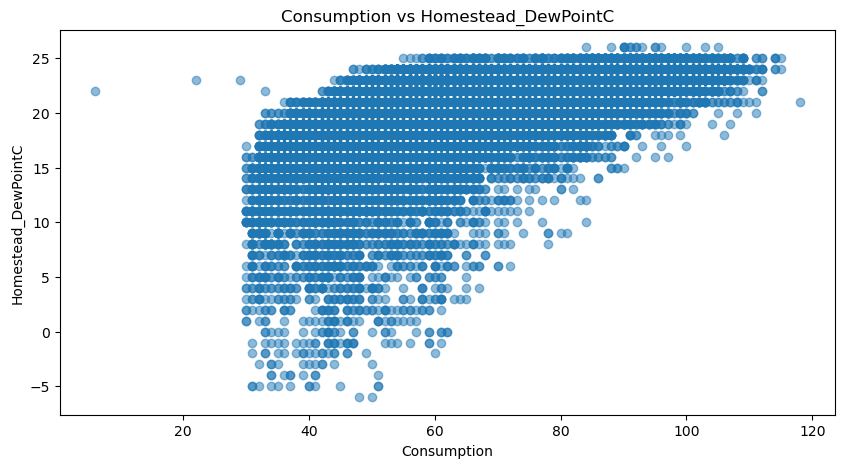

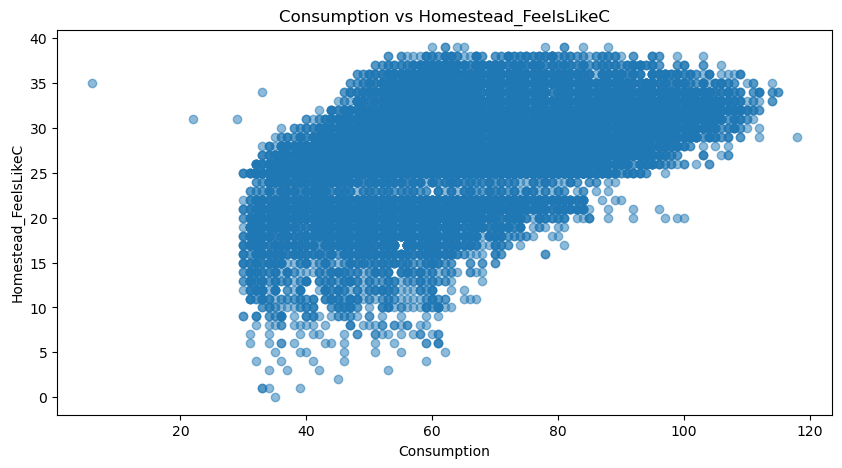

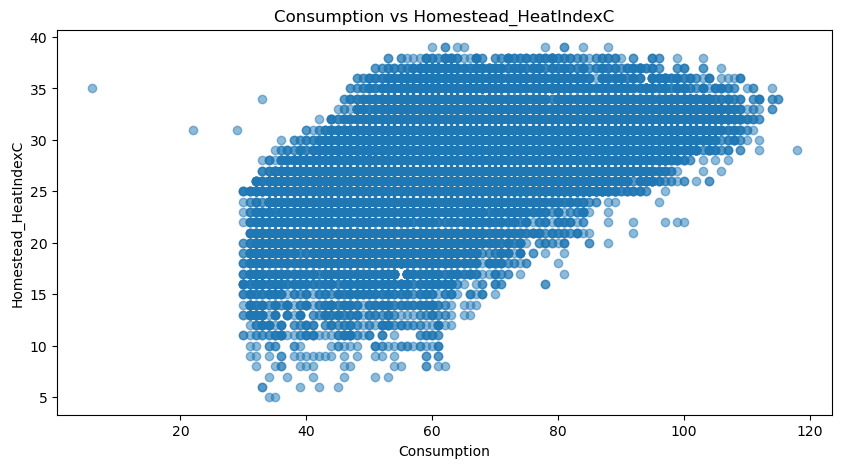

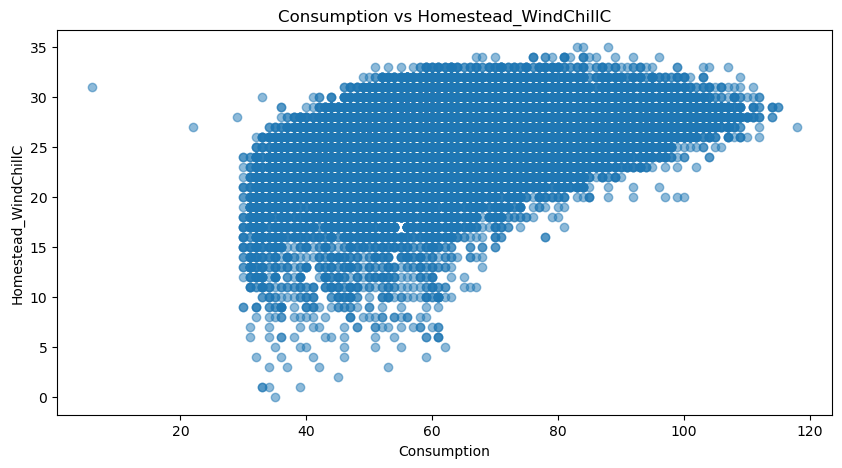

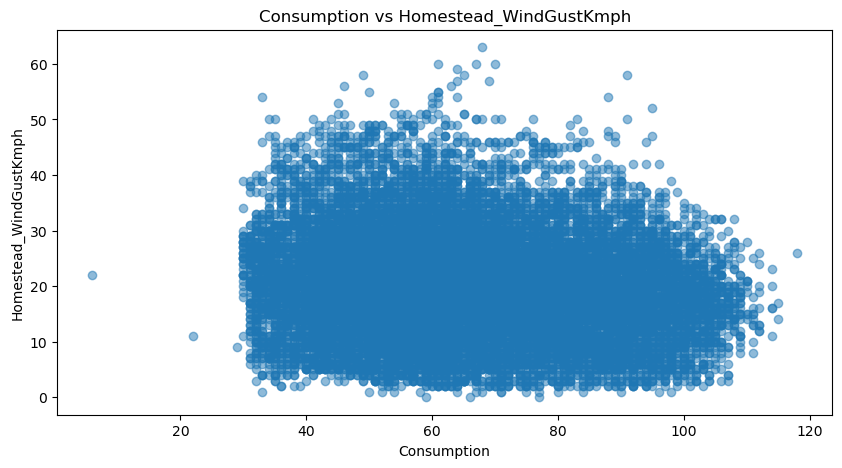

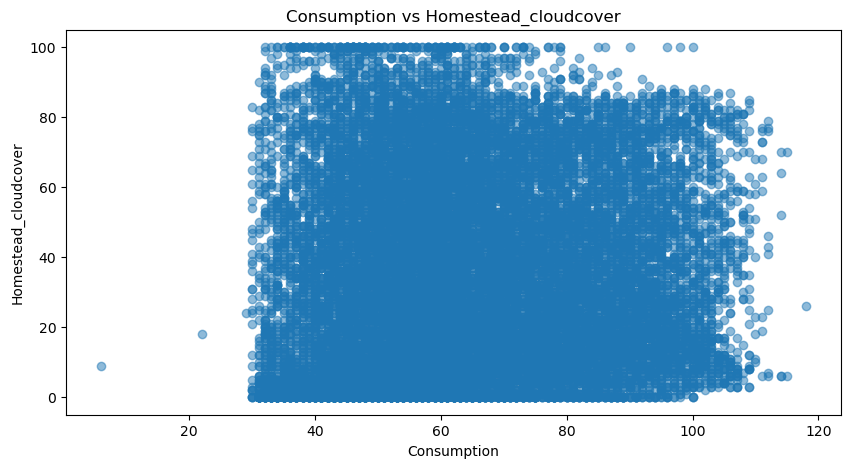

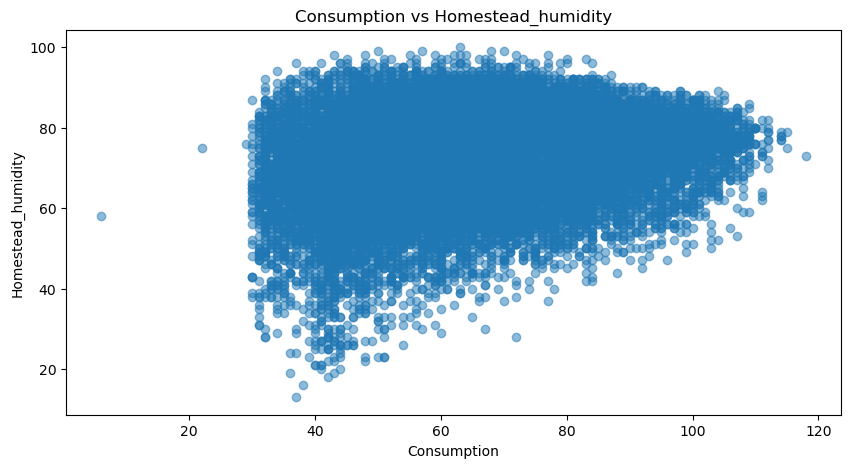

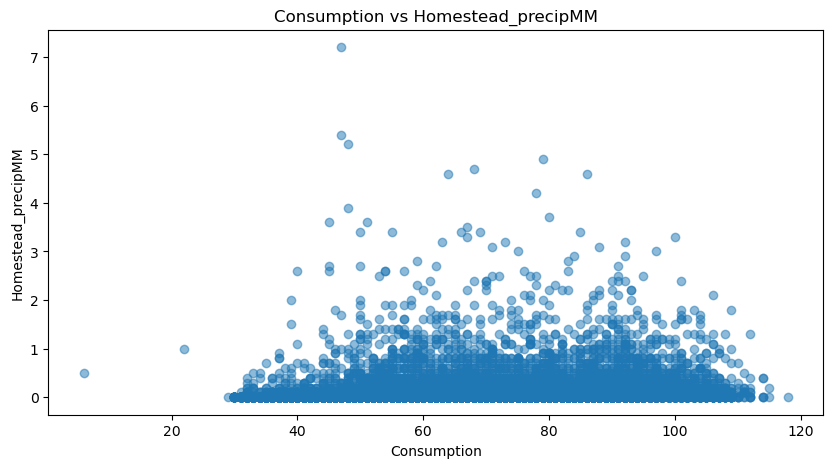

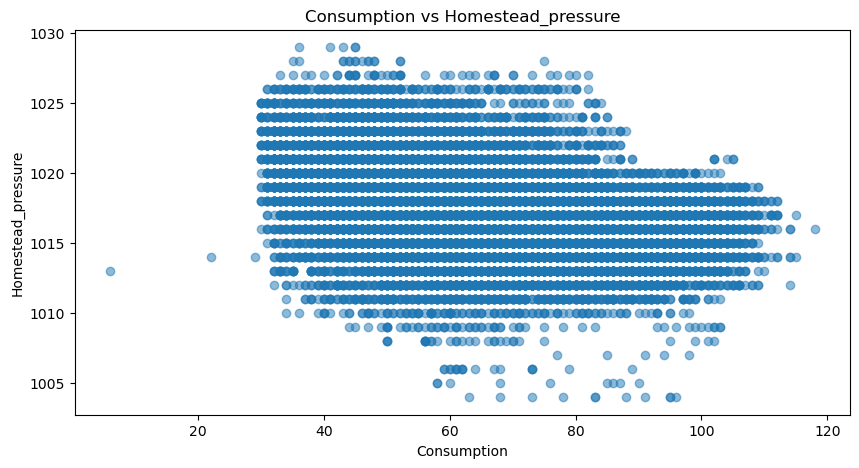

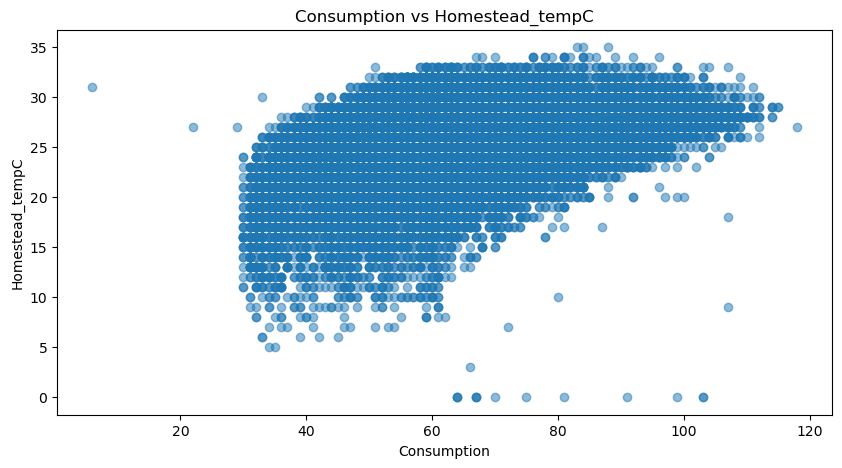

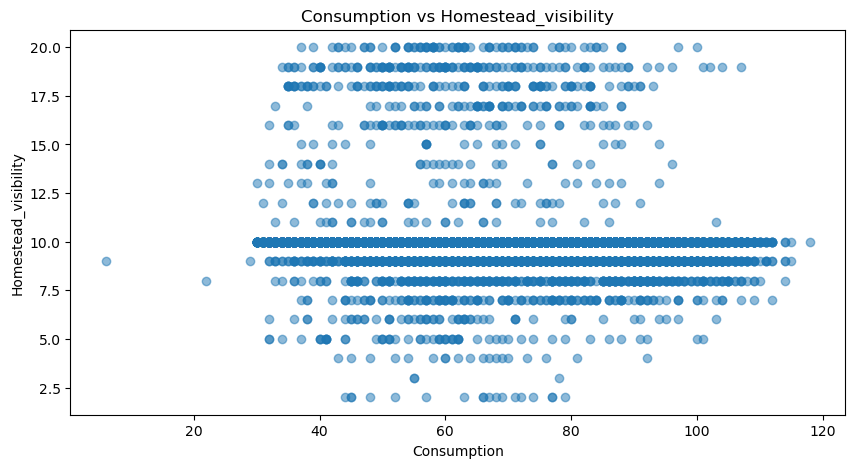

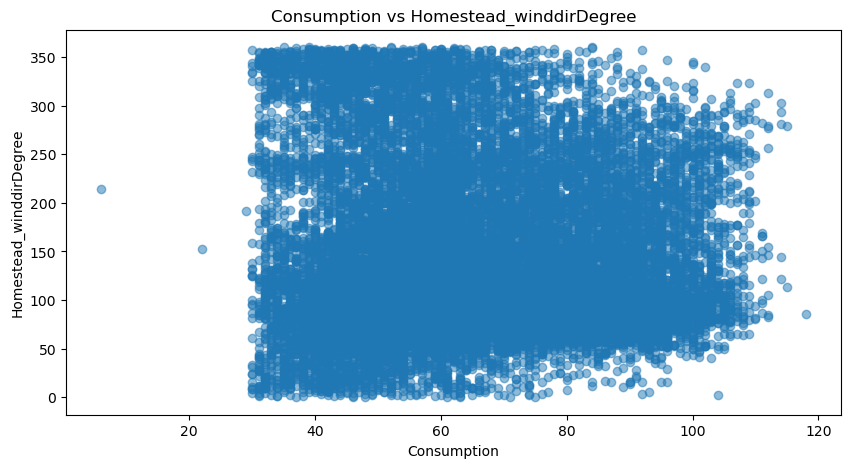

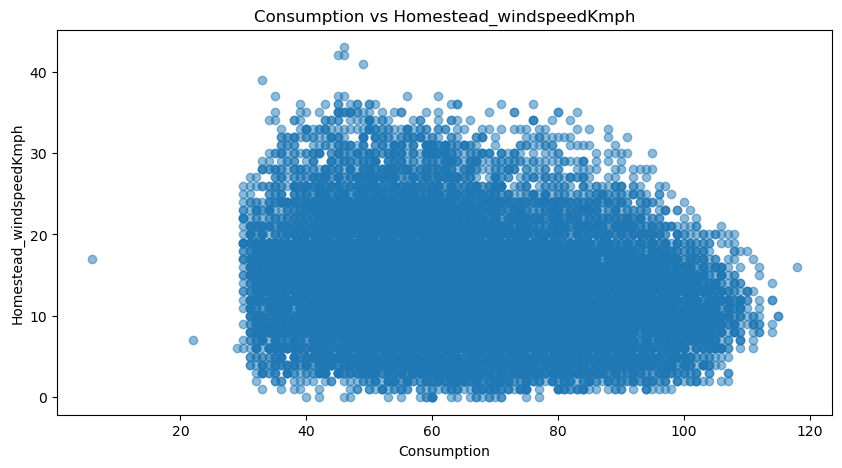

Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0143
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0014
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 8.3863e-04
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 5.5942e-04
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 4.7082e-04
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 4.5397e-04
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 4.7215e-04
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 4.3883e-04
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 4.2163e-04
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 4.0874e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Test RMSE: 14.51621444185639
Final Accuracy based on MAPE: 89.28938642044376 %


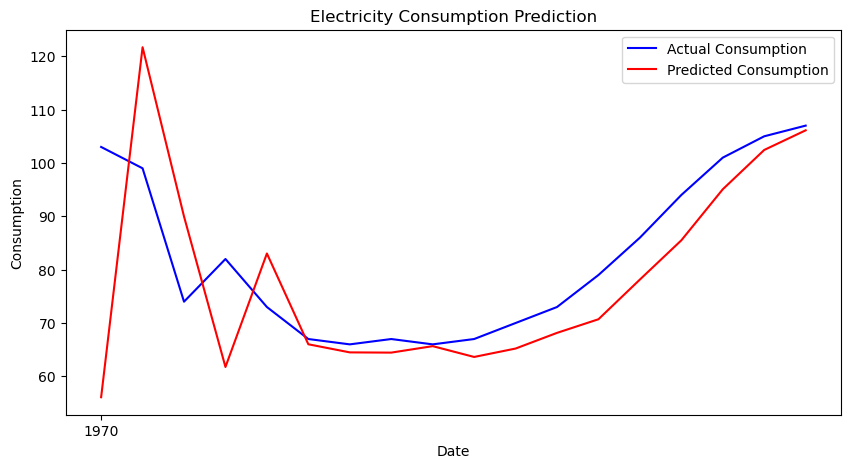

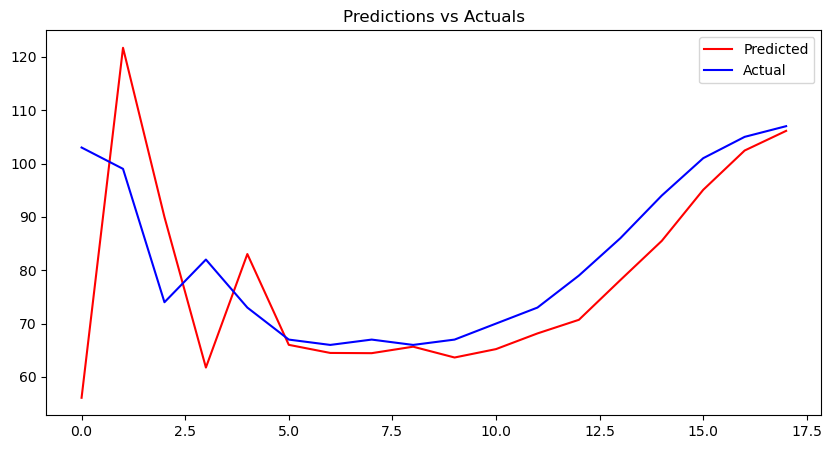

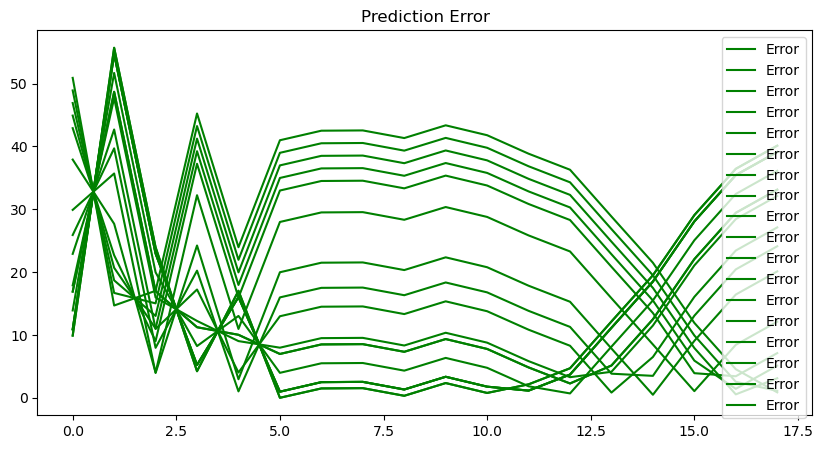

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error

# Load the datasets
data1 = pd.read_csv('electric_consumption_till_24june.csv')
data2 = pd.read_csv('electric_consumption_till_25jun (1).csv')

# Convert the date column to datetime, assuming the first column is the date
data1['Date'] = pd.to_datetime(data1.iloc[:, 0])
data2['Date'] = pd.to_datetime(data2.iloc[:, 0])

# Plot "Consumption" vs each other column in the first dataset
for column in data1.columns[1:]:  # Skip the date column
    if column != 'Consumption':  # Avoid plotting Consumption vs Consumption
        plt.figure(figsize=(10, 5))
        plt.scatter(data1['Consumption'], data1[column], alpha=0.5)
        plt.title(f"Consumption vs {column}")
        plt.xlabel("Consumption")
        plt.ylabel(column)
        plt.show()

# Preparing data for LSTM
# Extract the 'Consumption' values without column names for scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler.fit_transform(data1[['Consumption']].values)

# Define sequence length and reshape data
sequence_length = 60  # Number of time steps to look back
X_train, y_train = [], []
for i in range(sequence_length, len(data1_scaled)):
    X_train.append(data1_scaled[i-sequence_length:i, 0])
    y_train.append(data1_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test dataset
data_total = pd.concat((data1[['Consumption']], data2[['Consumption']]), axis=0)
inputs = data_total[len(data_total) - len(data2) - sequence_length:].values
inputs = scaler.transform(inputs)

X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and calculate accuracy
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

# Calculate RMSE for accuracy
test_data = data2['Consumption'].values
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse)

# Calculate final accuracy
mape = np.mean(np.abs((test_data - predictions.flatten()) / test_data)) * 100
accuracy = 100 - mape
print("Final Accuracy based on MAPE:", accuracy, "%")

# Plot the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(data2['Date'], test_data, color="blue", label="Actual Consumption")
plt.plot(data2['Date'], predictions, color="red", label="Predicted Consumption")
plt.title("Electricity Consumption Prediction")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

# Plot accuracy and error
plt.figure(figsize=(10, 5))
plt.plot(predictions, color="red", label="Predicted")
plt.plot(test_data, color="blue", label="Actual")
plt.title("Predictions vs Actuals")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(abs(predictions - test_data), color="green", label="Error")
plt.title("Prediction Error")
plt.legend()
plt.show()


Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0151
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 7.1525e-04
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.6799e-04
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 6.2367e-04
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 5.4998e-04
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.1162e-04
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 5.0889e-04
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 4.8407e-04
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 4.6815e-04
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 4.8151e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Test RMSE: 15.158937736735352
Final Accuracy based on MAPE: 88.91158516556536 %


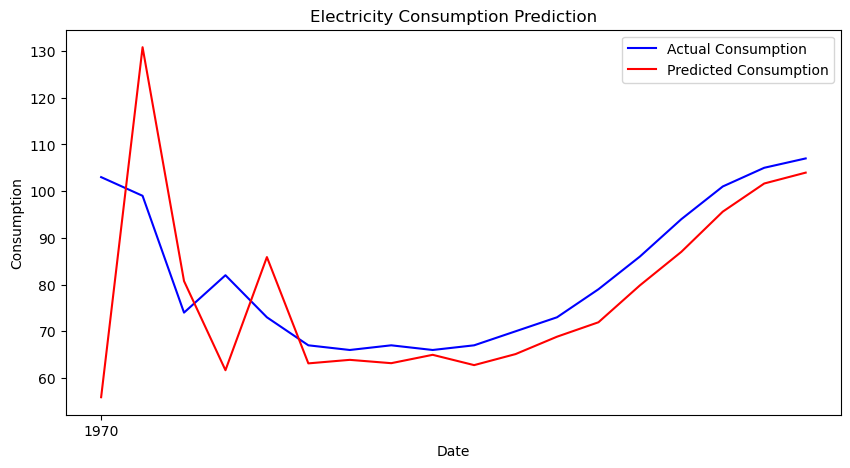

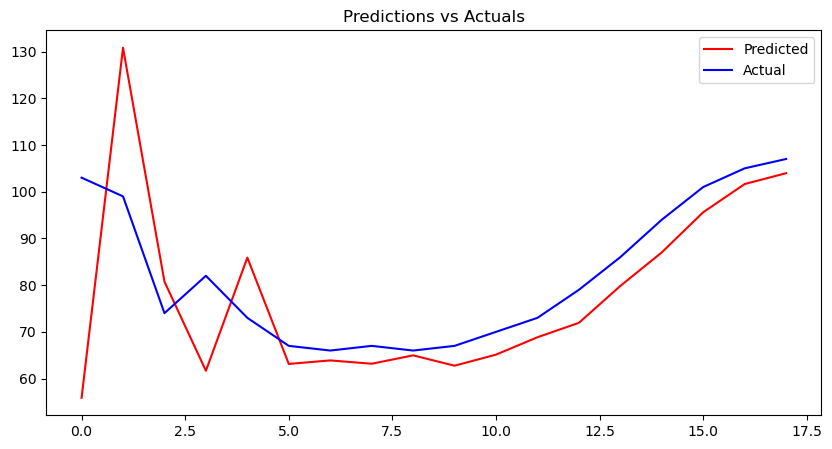

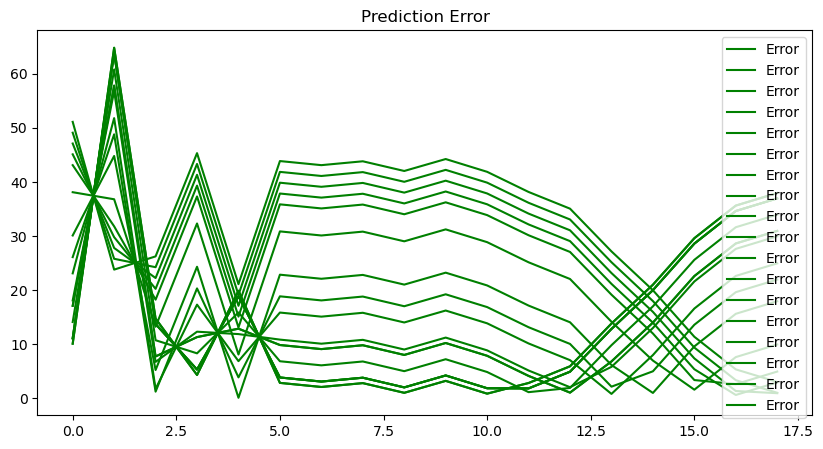

In [21]:
from tensorflow.keras.layers import GRU, Dense, Input
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    GRU(50, return_sequences=True),
    GRU(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test dataset
data_total = pd.concat((data1[['Consumption']], data2[['Consumption']]), axis=0)
inputs = data_total[len(data_total) - len(data2) - sequence_length:].values
inputs = scaler.transform(inputs)

X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and calculate accuracy
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

# Calculate RMSE for accuracy
test_data = data2['Consumption'].values
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse)

# Calculate final accuracy
mape = np.mean(np.abs((test_data - predictions.flatten()) / test_data)) * 100
accuracy = 100 - mape
print("Final Accuracy based on MAPE:", accuracy, "%")

# Plot the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(data2['Date'], test_data, color="blue", label="Actual Consumption")
plt.plot(data2['Date'], predictions, color="red", label="Predicted Consumption")
plt.title("Electricity Consumption Prediction")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

# Plot accuracy and error
plt.figure(figsize=(10, 5))
plt.plot(predictions, color="red", label="Predicted")
plt.plot(test_data, color="blue", label="Actual")
plt.title("Predictions vs Actuals")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(abs(predictions - test_data), color="green", label="Error")
plt.title("Prediction Error")
plt.legend()
plt.show()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, Attention, Concatenate
from sklearn.metrics import mean_squared_error
# Load the datasets
data1 = pd.read_csv('electric_consumption_till_24june.csv')
data2 = pd.read_csv('electric_consumption_till_25jun (1).csv')

# Convert the date column to datetime, assuming the first column is the date
data1['Date'] = pd.to_datetime(data1.iloc[:, 0])
data2['Date'] = pd.to_datetime(data2.iloc[:, 0])


In [25]:
# Preparing data for Seq2Seq
scaler = MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler.fit_transform(data1[['Consumption']].values)

sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(data1_scaled)):
    X_train.append(data1_scaled[i-sequence_length:i, 0])
    y_train.append(data1_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [27]:
# Define the Seq2Seq model with Attention
inputs = Input(shape=(X_train.shape[1], 1))  # Input shape: [samples, time steps, features]

# Encoder
encoder = GRU(50, return_sequences=True)(inputs)

# Attention mechanism
attention = Attention(use_scale=True)([encoder, encoder])  # Attention between the encoder and itself

# Concatenate the attention result with the encoder output
context_vector = Concatenate()([encoder, attention])

# Decoder
decoder = GRU(50, return_sequences=False)(context_vector)
decoder = RepeatVector(1)(decoder)  # Repeat to match the output shape

# Output layer
output = Dense(1)(decoder)

# Define the model
model = Model(inputs, output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 60, 50)    │      7,950 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 50)    │          1 │ gru_2[0][0],      │
│ (Attention)         │                   │            │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 100)   │          0 │ gru_2[0][0],      │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 50)        │     22,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 50)     │          0 │ gru_3[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 1)      │         51 │ repeat_vector[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,802 (120.32 KB)

 Trainable params: 30,802 (120.32 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0420
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0268
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0265
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0265
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0263
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0263
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0261
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0265
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0262
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0266


In [31]:
# Prepare the test dataset
data_total = pd.concat((data1[['Consumption']], data2[['Consumption']]), axis=0)
inputs = data_total[len(data_total) - len(data2) - sequence_length:].values
inputs = scaler.transform(inputs)

X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [35]:
# Predict and calculate accuracy
predictions = model.predict(X_test)

# Flatten the predictions to shape (samples, 1) before inverse scaling
predictions = predictions.reshape(predictions.shape[0], 1)

# Inverse scaling
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

# Calculate RMSE for accuracy
test_data = data2['Consumption'].values
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse)

# Calculate final accuracy using MAPE
mape = np.mean(np.abs((test_data - predictions.flatten()) / test_data)) * 100
accuracy = 100 - mape
print("Final Accuracy based on MAPE:", accuracy, "%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test RMSE: 23.849445928428192
Final Accuracy based on MAPE: 79.27872930059475 %


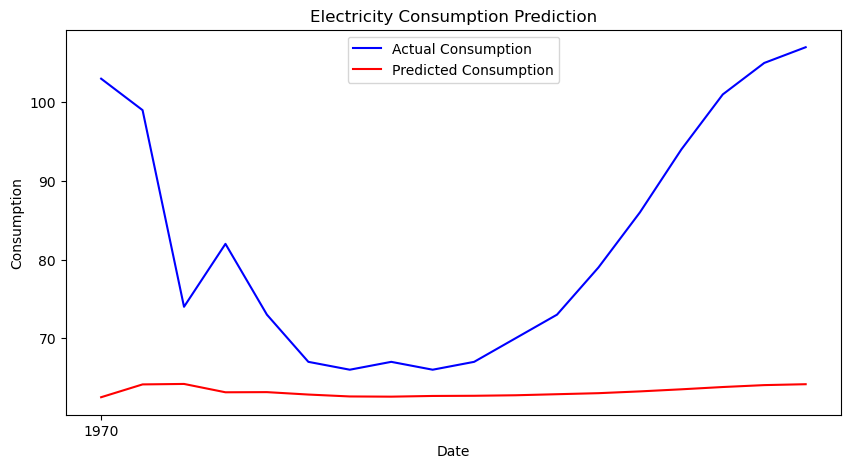

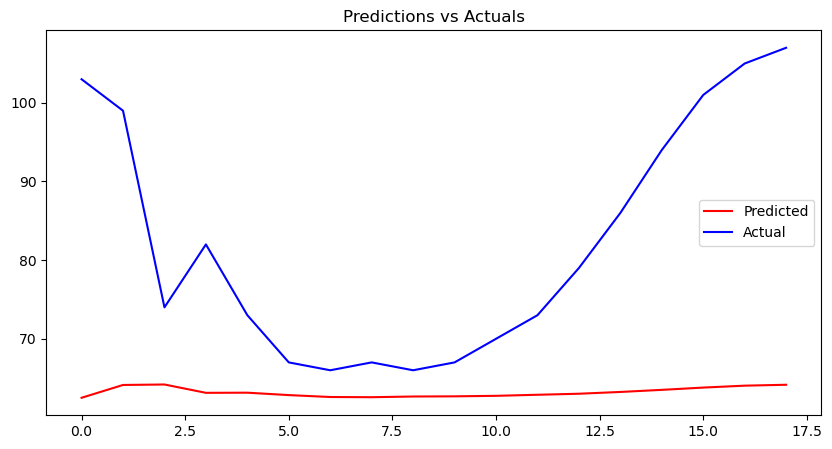

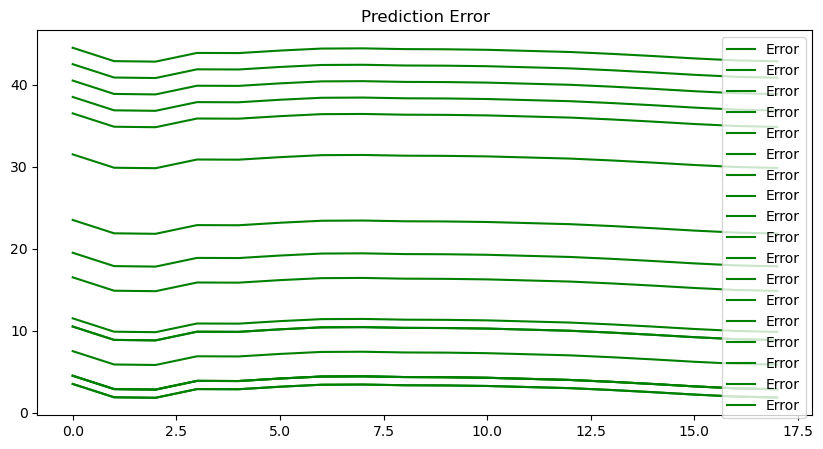

In [37]:
# Plot the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(data2['Date'], test_data, color="blue", label="Actual Consumption")
plt.plot(data2['Date'], predictions, color="red", label="Predicted Consumption")
plt.title("Electricity Consumption Prediction")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

# Plot accuracy and error
plt.figure(figsize=(10, 5))
plt.plot(predictions, color="red", label="Predicted")
plt.plot(test_data, color="blue", label="Actual")
plt.title("Predictions vs Actuals")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(abs(predictions - test_data), color="green", label="Error")
plt.title("Prediction Error")
plt.legend()
plt.show()


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input
from sklearn.metrics import mean_squared_error


In [55]:
# Load the datasets
data1 = pd.read_csv('electric_consumption_till_24june.csv')
data2 = pd.read_csv('electric_consumption_till_25jun (1).csv')

# Convert the date column to datetime, assuming the first column is the date
data1['Date'] = pd.to_datetime(data1.iloc[:, 0])
data2['Date'] = pd.to_datetime(data2.iloc[:, 0])

# Preparing data for the model
scaler = MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler.fit_transform(data1[['Consumption']].values)

# Define sequence length and reshape data
sequence_length = 60  # Number of time steps to look back
X_train, y_train = [], []
for i in range(sequence_length, len(data1_scaled)):
    X_train.append(data1_scaled[i-sequence_length:i, 0])
    y_train.append(data1_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for Conv1D [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



In [57]:
# Define the TCN model using Conv1D layers
model = Sequential()

# Adding causal convolutions with dilations (Temporal Convolutional Network)
model.add(Conv1D(filters=64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'))

# Flatten the output and add a Dense layer for the final prediction
model.add(Flatten())
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


C:\Users\nandi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 25)             │        96,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,011 (472.70 KB)

 Trainable params: 121,011 (472.70 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0102
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.5830e-04
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4613e-04
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3452e-04
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.2792e-04
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.5231e-04
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.0156e-04
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.1400e-04
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.5506e-04
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.1482e-04


In [61]:
# Prepare the test dataset
data_total = pd.concat((data1[['Consumption']], data2[['Consumption']]), axis=0)
inputs = data_total[len(data_total) - len(data2) - sequence_length:].values
inputs = scaler.transform(inputs)

X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and calculate accuracy
predictions = model.predict(X_test)

# Inverse scaling of predictions
predictions = predictions.reshape(predictions.shape[0], 1)  # Reshape for inverse transform
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE for accuracy
test_data = data2['Consumption'].values
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse)

# Calculate final accuracy using MAPE
mape = np.mean(np.abs((test_data - predictions.flatten()) / test_data)) * 100
accuracy = 100 - mape
print("Final Accuracy based on MAPE:", accuracy, "%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Test RMSE: 14.748032060279598
Final Accuracy based on MAPE: 89.58180478005715 %


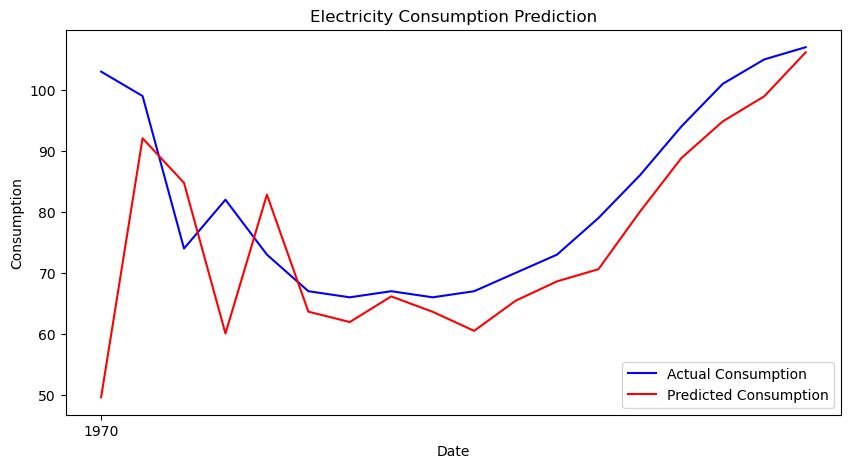

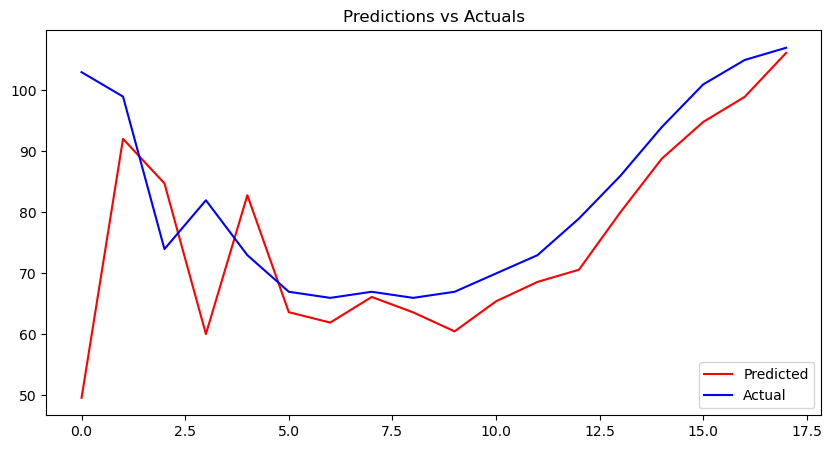

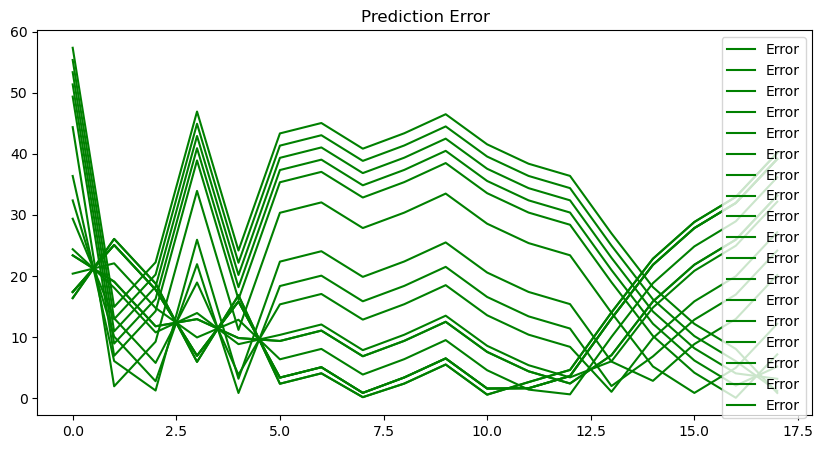

In [63]:
# Plot the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(data2['Date'], test_data, color="blue", label="Actual Consumption")
plt.plot(data2['Date'], predictions, color="red", label="Predicted Consumption")
plt.title("Electricity Consumption Prediction")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

# Plot accuracy and error
plt.figure(figsize=(10, 5))
plt.plot(predictions, color="red", label="Predicted")
plt.plot(test_data, color="blue", label="Actual")
plt.title("Predictions vs Actuals")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(abs(predictions - test_data), color="green", label="Error")
plt.title("Prediction Error")
plt.legend()
plt.show()
